In [1]:
import torch

torch.cuda.is_available()

True

## New Dataset

In [5]:
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

superclass_cols_defaults = ["NORM", "MI", "STTC", "HYP", "CD"]
SUBSAMPLE_SIZE = 1000


def load_signal_cube(signal_csv: Union[str, Path],
                     expected_channels: Optional[List[str]] = None,
                     expected_len: Optional[int] = None) -> Tuple[np.ndarray, Dict[int, int], List[str], int]:
    df = pd.read_csv(signal_csv)
    if "ecg_id" not in df.columns:
        raise ValueError(f"Missing 'ecg_id' column in {signal_csv}")

    df = df.sort_values("ecg_id", kind="mergesort").reset_index(drop=True)
    channel_cols = [col for col in df.columns if col != "ecg_id"]
    if expected_channels is not None and channel_cols != expected_channels:
        raise ValueError("Channel layout differs across splits")

    counts = df.groupby("ecg_id", sort=False).size()
    lengths = counts.unique()
    if len(lengths) != 1:
        raise ValueError("Signals have inconsistent lengths; expected a fixed 1000-sample window")
    signal_len = int(lengths[0])
    if expected_len is not None and signal_len != expected_len:
        raise ValueError("Signal length differs across splits")

    signal_cube = df[channel_cols].to_numpy(dtype=np.float32).reshape(-1, signal_len, len(channel_cols))
    ecg_ids = counts.index.to_numpy()
    id_lookup = {int(eid): idx for idx, eid in enumerate(ecg_ids)}
    return signal_cube, id_lookup, channel_cols, signal_len


def extract_single_subclass(meta_csv: Union[str, Path],
                            subclass_cols: Optional[List[str]] = None,
                            superclass_cols: Optional[List[str]] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray, int, List[str], List[str]]:
    meta_df = pd.read_csv(meta_csv)
    if "ecg_id" not in meta_df.columns:
        raise ValueError(f"Missing 'ecg_id' column in {meta_csv}")

    if subclass_cols is None:
        subclass_cols = [col for col in meta_df.columns if col.startswith("sub_")]
    missing_sub = [col for col in subclass_cols if col not in meta_df.columns]
    if missing_sub:
        raise ValueError(f"Columns {missing_sub} are missing from {meta_csv}")

    target_superclass_cols = superclass_cols or superclass_cols_defaults
    missing_super = [col for col in target_superclass_cols if col not in meta_df.columns]
    if missing_super:
        raise ValueError(f"Columns {missing_super} are missing from {meta_csv}")

    subset = meta_df[["ecg_id", *subclass_cols, *target_superclass_cols]].dropna(subset=["ecg_id"]).copy()
    subset["ecg_id"] = subset["ecg_id"].astype(int)
    subclass_values = subset[subclass_cols].fillna(0).astype(int).to_numpy()

    label_counts = (subclass_values > 0).sum(axis=1)
    single_mask = label_counts == 1
    dropped = int((~single_mask).sum())

    filtered_subset = subset[single_mask]
    filtered_ids = filtered_subset["ecg_id"].to_numpy()
    filtered_labels = np.array(subclass_cols)[subclass_values[single_mask].argmax(axis=1)]
    superclass_values = filtered_subset[target_superclass_cols].fillna(0).astype(int).to_numpy()

    return filtered_ids, filtered_labels, superclass_values, dropped, subclass_cols, target_superclass_cols


data_root = Path("/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/data/raw")
split_paths = {
    "train": {
        "signal": data_root / "train_signal.csv",
        "meta": data_root / "train_meta.csv",
    },
    "val": {
        "signal": data_root / "valid_signal.csv",
        "meta": data_root / "valid_meta.csv",
    },
    "test": {
        "signal": data_root / "test_signal.csv",
        "meta": data_root / "test_meta.csv",
    },
}

csv_splits: Dict[str, Dict[str, np.ndarray]] = {}
expected_channels: Optional[List[str]] = None
expected_len: Optional[int] = None
subclass_cols: Optional[List[str]] = None
superclass_cols: Optional[List[str]] = None

for split_name, paths in split_paths.items():
    signals, lookup, channel_cols, signal_len = load_signal_cube(
        paths["signal"], expected_channels=expected_channels, expected_len=expected_len
    )
    if expected_channels is None:
        expected_channels = channel_cols
    if expected_len is None:
        expected_len = signal_len

    ids, labels, superclass_values, dropped, subclass_cols, detected_superclasses = extract_single_subclass(
        paths["meta"], subclass_cols=subclass_cols, superclass_cols=superclass_cols
    )

    if superclass_cols is None:
        superclass_cols = detected_superclasses

    missing = [eid for eid in ids if eid not in lookup]
    if missing:
        raise ValueError(f"{split_name} meta rows missing signal data: {missing[:3]} ...")

    ordered_indices = [lookup[int(eid)] for eid in ids]
    
    # Subsample to reduce memory usage
    n_samples = len(ordered_indices)
    if n_samples > SUBSAMPLE_SIZE:
        rng = np.random.default_rng(seed=42)
        subsample_idx = rng.choice(n_samples, size=SUBSAMPLE_SIZE, replace=False)
        subsample_idx = np.sort(subsample_idx)
        ordered_indices = [ordered_indices[i] for i in subsample_idx]
        ids = ids[subsample_idx]
        labels = labels[subsample_idx]
        superclass_values = superclass_values[subsample_idx]
    
    csv_splits[split_name] = {
        "X": signals[ordered_indices],
        "labels": labels,
        "ecg_ids": ids,
        "dropped_multi_label": dropped,
        "superclasses": superclass_values,
    }

label_encoder = LabelEncoder()
label_encoder.fit(
    np.concatenate([csv_splits["train"]["labels"], csv_splits["val"]["labels"], csv_splits["test"]["labels"]])
)

for split_data in csv_splits.values():
    split_data["y_int"] = label_encoder.transform(split_data["labels"])

label_to_idx = {label: int(idx) for idx, label in enumerate(label_encoder.classes_)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

X_train_filtered = csv_splits["train"]["X"]
y_train_int = csv_splits["train"]["y_int"]
X_val_filtered = csv_splits["val"]["X"]
y_val_int = csv_splits["val"]["y_int"]
X_test_filtered = csv_splits["test"]["X"]
y_test_int = csv_splits["test"]["y_int"]

Y_train_superclasses = csv_splits["train"]["superclasses"]
Y_val_superclasses = csv_splits["val"]["superclasses"]
Y_test_superclasses = csv_splits["test"]["superclasses"]

print(f"Loaded CSV-based splits (subsampled to max {SUBSAMPLE_SIZE} per split, single subclass per record):")
for split_name in ["train", "val", "test"]:
    split = csv_splits[split_name]
    print(
        f"  {split_name.title():>5}: X={split['X'].shape}, unique subclasses={np.unique(split['labels']).size}, "
        f"dropped multi-label rows={split['dropped_multi_label']}, superclasses shape={split['superclasses'].shape}"
    )
print(f"Subclass count: {len(label_encoder.classes_)}")
print(f"Superclass columns: {superclass_cols}")

Loaded CSV-based splits (subsampled to max 1000 per split, single subclass per record):
  Train: X=(1000, 1000, 12), unique subclasses=19, dropped multi-label rows=5318, superclasses shape=(1000, 5)
    Val: X=(1000, 1000, 12), unique subclasses=19, dropped multi-label rows=638, superclasses shape=(1000, 5)
   Test: X=(1000, 1000, 12), unique subclasses=20, dropped multi-label rows=642, superclasses shape=(1000, 5)
Subclass count: 21
Superclass columns: ['NORM', 'MI', 'STTC', 'HYP', 'CD']


### Prepare CSV-based train/val/test splits
Run this section when you want to drive the rest of the notebook with the reformatted CSV exports (skipping the older PTB-XL reader below).

# Augmentation Analysis
The model is currently unable to learn meaningful representations of the data, even though the loss decreases during training.  
This can imply that the augmentations break the patterns between the signals and each other.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def check_spectral_consistency(original_ecg, augmented_ecg, fs=125):
    """
    Plots the PSD of the original vs augmented signal.
    fs: Sampling frequency of your ECG (e.g., 125Hz, 250Hz, 500Hz)
    """
    
    # 1. Compute Welch's Periodogram (Smoothed FFT) for Original
    freqs_orig, psd_orig = signal.welch(original_ecg, fs, nperseg=1024)
    
    # 2. Compute Welch's Periodogram for Augmented
    freqs_aug, psd_aug = signal.welch(augmented_ecg, fs, nperseg=1024)

    # 3. Plotting
    plt.figure(figsize=(10, 6))
    
    # Log-Log plot is usually best for bio-signals to see wide dynamic range
    plt.semilogy(freqs_orig, psd_orig, label='Original', color='black', alpha=0.8)
    plt.semilogy(freqs_aug, psd_aug, label='Augmented', color='red', alpha=0.6, linestyle='--')
    
    plt.title("Spectral Consistency Check")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (V**2/Hz)')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.show()

# Example Usage
# original_batch = load_your_data()
# augmented_batch = your_augmentation_function(original_batch)
# check_spectral_consistency(original_batch[0], augmented_batch[0], fs=100)

In [19]:
import ecgmentations as E
from src import DualAugmenter

# Define augmentation pool (same as used in training)
# augmentation_pool = [
#     E.Sequential(
#         [
#         # 1. First, change the geometry (Shift/Cutout/Warp)
#         E.RandomResizedCrop(scale=(0.8, 1.0)), # Highly recommended for Contrastive Learning
        
#         # 2. Then, add physics/noise
#         E.RandomApply([E.GaussNoise()], p=0.5),
        
#         # 3. Finally, scale
#         E.AmplitudeScale()
#     ]
#         )
# ]

dual_augmenter = DualAugmenter(
    augmentation_pool=augmentation_pool,
    min_similarity=0.35,
    max_similarity=0.80,
    max_retries=5,
)

# Select a sample and a lead to analyze
sample_idx = 0
lead_idx = 1  # Lead II

original_signal = X_train_filtered[sample_idx]  # Shape: (time_steps, num_channels)

# Normalize like the dataset does
channel_means = np.mean(X_train_filtered, axis=(0, 1))
channel_stds = np.std(X_train_filtered, axis=(0, 1))
channel_stds = np.maximum(channel_stds, 1e-8)
normalized_signal = (original_signal - channel_means) / channel_stds

# Apply augmentation via DualAugmenter
aug1, aug2 = dual_augmenter(ecg=normalized_signal)

# Extract single lead for spectral analysis
original_lead = normalized_signal[:, lead_idx]
augmented_lead = aug2[:, lead_idx]

# Run spectral consistency check
print(f"Analyzing sample {sample_idx}, Lead II")
print(f"Original signal shape: {original_lead.shape}")
print(f"Augmented signal shape: {augmented_lead.shape}")
check_spectral_consistency(original_lead, augmented_lead, fs=100)  # PTB-XL uses 100Hz for low-res

Analyzing sample 0, Lead II
Original signal shape: (1000,)
Augmented signal shape: (1000,)


NameError: name 'check_spectral_consistency' is not defined

Analyzing sample 0, Lead II
Original signal shape: (1000,)
Augmented signal shape: (1000,)


/tmp/ipykernel_4068456/541351149.py:12: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 1000, using nperseg = 1000
  freqs_orig, psd_orig = signal.welch(original_ecg, fs, nperseg=1024)
/tmp/ipykernel_4068456/541351149.py:15: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 1000, using nperseg = 1000
  freqs_aug, psd_aug = signal.welch(augmented_ecg, fs, nperseg=1024)


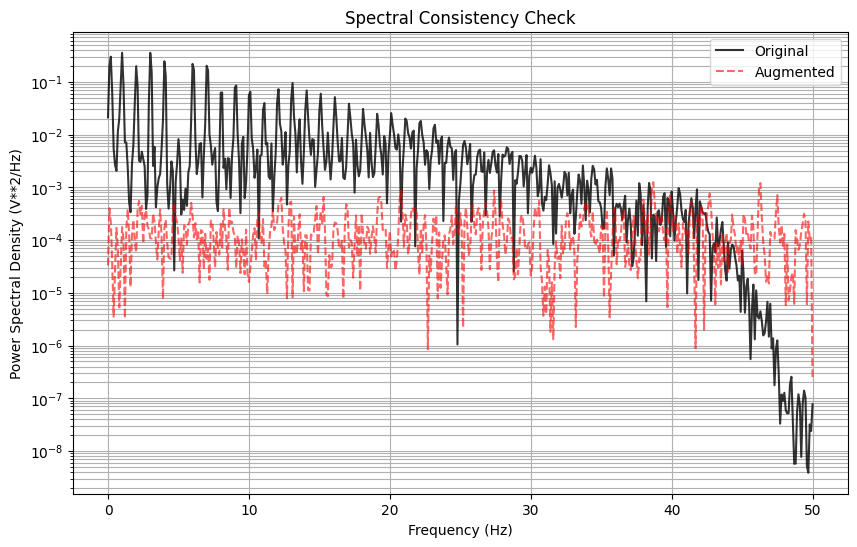

In [33]:
import ecgmentations as E
from src import DualAugmenter
import numpy as np

# Define augmentation pool (same as used in training)
class ChannelMasking(E.EcgOnlyAugmentation):
    """Randomly masks (zeros out) each ECG lead independently with probability p."""
    
    def __init__(self, p: float = 0.5):
        super(ChannelMasking, self).__init__(always_apply=True, p=1.0)
        self.mask_prob = p
    
    def __call__(self, **ecg):
        ecg_augmented = ecg["ecg"].copy()
        num_channels = ecg_augmented.shape[1]
        
        # Each lead is masked independently with probability mask_prob
        mask = np.random.random(num_channels) < self.mask_prob
        ecg_augmented[:, mask] = 0.0
        
        return {"ecg": ecg_augmented}

augmentation_pool = [
    E.Sequential(
        [
    ChannelMasking(p=0.5),
    E.GaussNoise(always_apply=True)
        ]    ),
]

dual_augmenter = DualAugmenter(
    augmentation_pool=augmentation_pool,
    min_similarity=0.35,
    max_similarity=0.95,
    max_retries=1,
)

# Select a sample and a lead to analyze
sample_idx = 0
lead_idx = 1  # Lead II

original_signal = X_train_filtered[sample_idx]  # Shape: (time_steps, num_channels)

# Normalize like the dataset does
channel_means = np.mean(X_train_filtered, axis=(0, 1))
channel_stds = np.std(X_train_filtered, axis=(0, 1))
channel_stds = np.maximum(channel_stds, 1e-8)
normalized_signal = (original_signal - channel_means) / channel_stds

# Apply augmentation via DualAugmenter
aug1, aug2 = dual_augmenter(ecg=normalized_signal)

# Extract single lead for spectral analysis
original_lead = normalized_signal[:, lead_idx]
augmented_lead = aug2[:, lead_idx]

# Run spectral consistency check
print(f"Analyzing sample {sample_idx}, Lead II")
print(f"Original signal shape: {original_lead.shape}")
print(f"Augmented signal shape: {augmented_lead.shape}")
check_spectral_consistency(original_lead, augmented_lead, fs=100)  # PTB-XL uses 100Hz for low-res